## Object Detection - TensorFlow SSD model

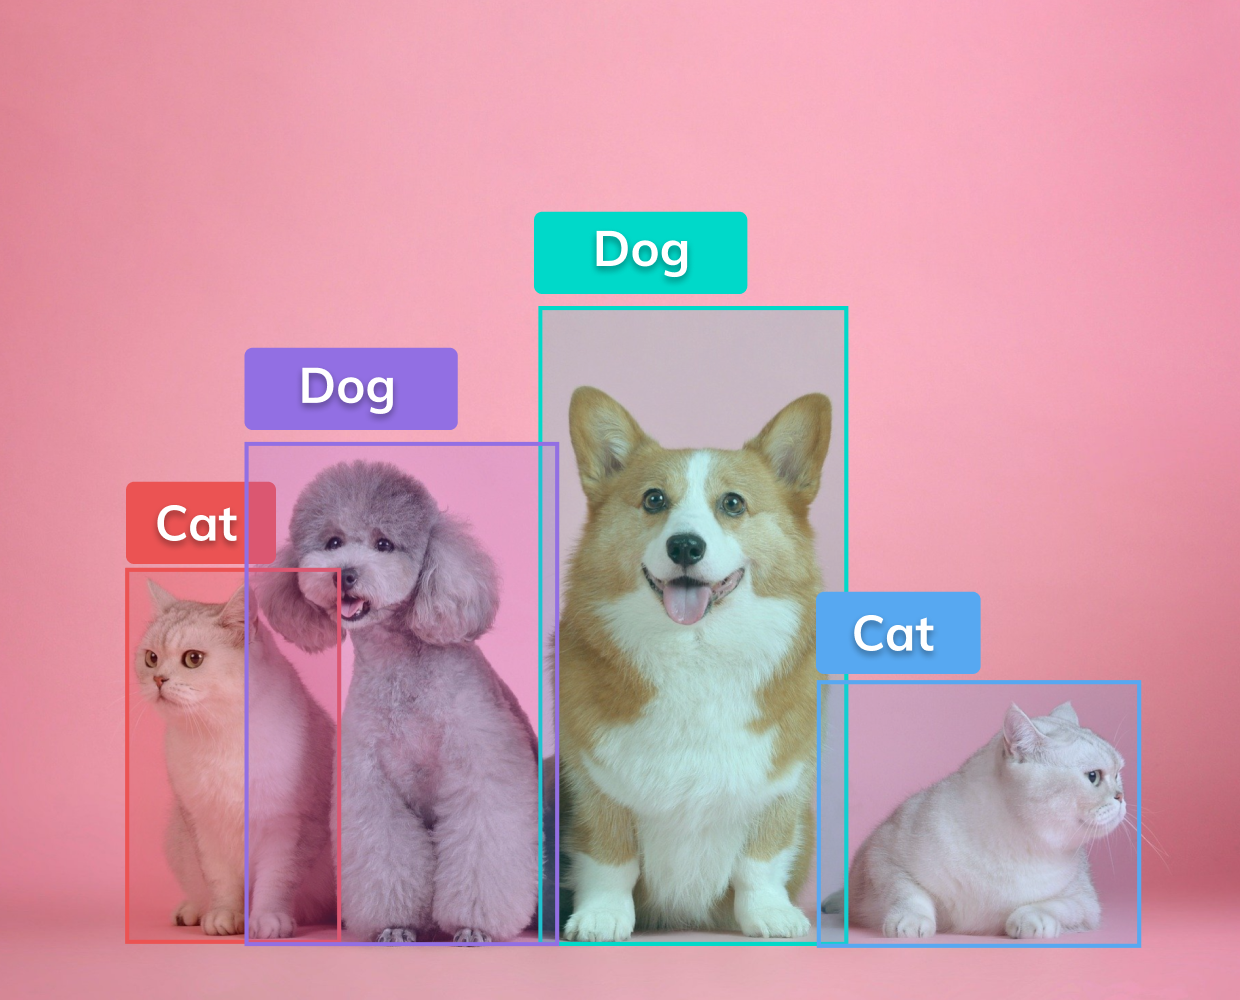

In [1]:
from IPython.display import Image
Image("https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/627d124572023b6948b6cdff_60ed9a4e09e2c648f1b8a013_object-detection-cover.png")

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [32]:
import os
import json
import logging
from datetime import datetime

<IPython.core.display.Javascript object>

In [14]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris, model_uris, script_uris
from sagemaker.estimator import Estimator
from sagemaker import hyperparameters

<IPython.core.display.Javascript object>

In [4]:
boto3.set_stream_logger(name="botocore.credentials", level=logging.WARNING)

<IPython.core.display.Javascript object>

In [5]:
sess = sagemaker.Session()
region = sess.boto_region_name
print(region)

<sagemaker.session.Session object at 0x7fe360abadf0> ap-southeast-2


<IPython.core.display.Javascript object>

In [6]:
# role_arn = sagemaker.get_execution_role()
role_arn = os.getenv("SGMKR_ROLE_ARN")

<IPython.core.display.Javascript object>

In [20]:
bucket_name = "sgmkr-course"
data_path = "sgmkr_od_tf"

# nclasses = 3
# nimgs_train = 36
nepochs = 10
mini_batch_size = 8

train_instance_type = "ml.g4dn.xlarge"
job_name_prefix = "flowers-od-js-tf-"

<IPython.core.display.Javascript object>

In [11]:
model_id = "tensorflow-od1-ssd-resnet50-v1-fpn-640x640-coco17-tpu-8"
model_version = "*"
train_instance_type = "ml.g4dn.xlarge"

<IPython.core.display.Javascript object>

In [12]:
train_image_uri = image_uris.retrieve(
    model_id=model_id,
    model_version=model_version,
    image_scope="training",
    instance_type=train_instance_type,
    region=None,
    framework=None,
)

train_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="training"
)

train_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="training"
)

print(train_image_uri)
print(train_source_uri)
print(train_model_uri)

image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/tensorflow-training:2.11.0-gpu-py39
s3://jumpstart-cache-prod-ap-southeast-2/source-directory-tarballs/tensorflow/transfer_learning/od1/v1.0.1/sourcedir.tar.gz
s3://jumpstart-cache-prod-ap-southeast-2/tensorflow-training/train-tensorflow-od1-ssd-resnet50-v1-fpn-640x640-coco17-tpu-8.tar.gz


<IPython.core.display.Javascript object>

In [15]:
s3_output_path = "s3://{}/{}/{}".format(bucket_name, data_path, "model_output")

<IPython.core.display.Javascript object>

In [16]:
hyperparameters = hyperparameters.retrieve_default(
    model_id=model_id, 
    model_version=model_version
)
print(hyperparameters)
hyperparameters["epochs"] = "5"
hyperparameters['train_only_top_layer'] = True

{'batch_size': '3', 'reinitialize_top_layer': 'Auto', 'train_only_top_layer': 'False', 'optimizer': 'adam', 'learning_rate': '0.001', 'beta_1': '0.9', 'beta_2': '0.999', 'momentum': '0.9', 'epsilon': '1e-07', 'rho': '0.95', 'initial_accumulator_value': '0.1', 'early_stopping': 'False', 'early_stopping_patience': '5', 'early_stopping_min_delta': '0.0', 'epochs': '5'}


<IPython.core.display.Javascript object>

In [17]:
tf_od_estimator = Estimator(
    role=role_arn,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=train_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_path,
)

<IPython.core.display.Javascript object>

In [18]:
s3_train_imgs_annot = "s3://{}/{}/{}".format(bucket_name, data_path, "train/")
s3_valid_imgs_annot = "s3://{}/{}/{}".format(bucket_name, data_path, "valid/")

data_channels = {
    "training": s3_train_imgs_annot,
    # "validation": s3_valid_imgs_annot,
}
print(data_channels)

{'training': 's3://sgmkr-course/sgmkr_od_tf/train/'}


<IPython.core.display.Javascript object>

In [19]:
timestamp = (
    str(datetime.now().replace(microsecond=0)).replace(" ", "-").replace(":", "-")
)
job_name = job_name_prefix + timestamp
print(job_name)

flowers-od-js-tf2023-03-21-15-55-45


<IPython.core.display.Javascript object>

In [22]:
tf_od_estimator.fit(inputs=data_channels, logs=True, job_name=job_name)

Creating training-job with name: flowers-od-js-tf2023-03-21-15-55-45


2023-03-21 05:06:52 Starting - Starting the training job...
2023-03-21 05:07:08 Starting - Preparing the instances for training...
2023-03-21 05:07:57 Downloading - Downloading input data...
2023-03-21 05:08:22 Training - Downloading the training image.....................
2023-03-21 05:11:48 Training - Training image download completed. Training in progress.2023-03-21 05:11:58.442239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 05:11:58.571228: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-03-21 05:11:58.571401: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread wil

2023-03-21 05:12:02.548532: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-03-21 05:12:02.548717: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-03-21 05:12:02.594952: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
Running training scripts with arguments: Namespace(model_dir='/opt/ml/model', train='/opt/ml/input/data/training', validation=None, pretrained_model='/opt/ml/input/data/model', validation_split_ratio=0.2, epochs=5, batch_size=3, reinitialize_top_layer='Auto', train_only_top_layer='False', checkpoint_save_best_only='True', optimizer='adam', learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, momentum=0.9, rho=0.95, initial_accumulator_value=0.1, early_stopping='False', early_stopping_patience=5, early_stopping_mi

W0321 05:15:42.534357 140421194999616 save_impl.py:66] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7fb5ec7a3610>, because it is not built.
W0321 05:16:01.078212 140421194999616 save.py:271] Found untraced functions such as WeightSharedConvolutionalBoxPredictor_layer_call_fn, WeightSharedConvolutionalBoxPredictor_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxHead_layer_call_fn, WeightSharedConvolutionalBoxHead_layer_call_and_return_conditional_losses, WeightSharedConvolutionalClassHead_layer_call_fn while saving (showing 5 of 278). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /opt/ml/model/saved_model/assets
I0321 05:16:07.984479 140421194999616 builder_impl.py:797] Assets written to: /opt/ml/model/saved_model/assets
INFO:tensorflow:Writing pipeline config file to /opt/ml/model/pipeline.config
I0321 05:16:09.421198 140421194999616 config_ut

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
infer_instance_type = "ml.t2.medium"

<IPython.core.display.Javascript object>

In [26]:
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=infer_instance_type,
)

deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)

Ignoring unnecessary Python version: py39.


<IPython.core.display.Javascript object>

In [27]:
model_name = job_name
endpoint_name = job_name

<IPython.core.display.Javascript object>

In [28]:
od_predictor = tf_od_estimator.deploy(
    initial_instance_count=1,
    instance_type=infer_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
    model_name=model_name,
)

Creating model with name: flowers-od-js-tf2023-03-21-15-55-45
Creating endpoint-config with name flowers-od-js-tf2023-03-21-15-55-45
Creating endpoint with name flowers-od-js-tf2023-03-21-15-55-45


----------!

<IPython.core.display.Javascript object>

In [29]:
sgmkr_runt = boto3.client("runtime.sagemaker")

<IPython.core.display.Javascript object>

In [33]:
with open("images/rose.jpg", "rb") as image:
    payload = image.read()
    # payload = bytearray(payload)

response = sgmkr_runt.invoke_endpoint(
    EndpointName=endpoint_name,
    # ContentType = 'image/jpeg',
    ContentType="application/x-image",
    Accept="application/json;n_predictions=5",
    Body=payload,
)

prediction = json.loads(response["Body"].read().decode())
print(prediction)

{'normalized_boxes': [[0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0]], 'classes': [3.0, 3.0, 3.0, 3.0, 3.0], 'scores': [0.213013142, 0.213013172, 0.213013172, 0.213013172, 0.213013172]}


<IPython.core.display.Javascript object>

In [34]:
od_predictor.delete_endpoint()

Deleting endpoint configuration with name: flowers-od-js-tf2023-03-21-15-55-45
Deleting endpoint with name: flowers-od-js-tf2023-03-21-15-55-45


<IPython.core.display.Javascript object>